# Executive Summary

This notebook will attempt to answer the following research question:

    What's money got to do with it?

## PLANNING

- [X] Planning
    - [X] import libraries/packages
    - [X] configure notebook environment
    - [X] define helper functions
- [X] Acquire data
    - [X] get PEIMS financial data
    - [X] get STAAR performance data
- [X] Prepare the data
    - [X] prepare PEIMS data
        - [X] get rid of unwanted columns
        - [x] get rid of NaNs
    - [X] prepare STAAR data
        - [X] get rid of duplicates
        - [X] get rid of unwanted columns
        - [X] get rid of NaNs
        - [X] create new columns
        - [X] merge two datasets together
- [ ] Explore the data
    - [ ] examine for multicollinearity and determine truly independent variables
    - [ ] get to know the master dataset
    - [ ] feature engineering
- [ ] Modeling
    - [X] create, fit, use XGBoost
    - [ ] gridsearch
    - [ ] retrain model using best hyperparameters
    - [X] extract feature importances

In [88]:
# setting the random seed for reproducibility
import random
random.seed(493)

# for manipulating dataframes
import pandas as pd
import numpy as np

# for modeling
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle

# for statistical testing
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu


# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
def show_missing(df):
    """
    Takes a dataframe and returns a dataframe with stats
    on missing and null values with their percentages.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    dfx = pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})
    return dfx

In [3]:
def get_values(df, columns):
    """
    Take a dataframe and a list of columns and
    returns the value counts for the columns.
    """
    for column in columns:
        print(column)
        print('=====================================')
        print(df[column].value_counts(dropna=False))
        print('\n')

def show_values(df, param):
    if param == 'all':
        get_values(df, df.columns)
    else:
        get_values(df, param)

## ACQUIRE DATA

In [4]:
# Get the PEIMS and STAAR datasets
peims_df = pd.read_csv('../data/in/2007-2021-summaried-peims-financial-data.csv')
staar_df1 = pd.read_csv('../data/in/tidy_campstaar1_2012to2019.csv')
staar_df2 = pd.read_csv('../data/in/tidy_campstaar2_2013to2019.csv')

C:\Users\Dd\AppData\Local\Temp\ipykernel_19596\2859202939.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  staar_df1 = pd.read_csv('../data/in/tidy_campstaar1_2012to2019.csv')


## PREPARATION

### STARR Dataset

In [5]:
# Take a peek
staar_df1.head()
staar_df2.head()

,data_release,data_category,data_level,release_year,test_year,campus_number,grade_level,subject,proficiency,demog,numerator,denominator,new_rate
0,tapr,CAMPSTAAR1.csv,campus,2014,2013,1902001,eoc,algebra_1,approaches,all_students,41,48,85.42
1,tapr,CAMPSTAAR1.csv,campus,2014,2014,1902001,eoc,algebra_1,approaches,all_students,51,57,89.47
2,tapr,CAMPSTAAR1.csv,campus,2014,2013,1902001,eoc,algebra_1,approaches,at_risk,11,17,64.71
3,tapr,CAMPSTAAR1.csv,campus,2014,2014,1902001,eoc,algebra_1,approaches,at_risk,32,38,84.21
4,tapr,CAMPSTAAR1.csv,campus,2014,2013,1902001,eoc,algebra_1,approaches,economic_disadvant,17,20,85.00


,data_release,data_category,data_level,release_year,test_year,campus_number,grade_level,subject,proficiency,demog,numerator,denominator,new_rate
0,tapr,CAMPSTAAR2.csv,campus,2019,2019,1902001,eoc,english_i,approaches,all_students,40,51,78.43
1,tapr,CAMPSTAAR2.csv,campus,2019,2019,1903001,eoc,english_i,approaches,all_students,88,127,69.29
2,tapr,CAMPSTAAR2.csv,campus,2019,2019,1904001,eoc,english_i,approaches,all_students,50,72,69.44
3,tapr,CAMPSTAAR2.csv,campus,2019,2019,1906002,eoc,english_i,approaches,all_students,21,28,75.00
4,tapr,CAMPSTAAR2.csv,campus,2019,2019,1907001,eoc,english_i,approaches,all_students,245,382,64.14


In [6]:
# Get the number of rows and columns
peims_df.shape
staar_df1.shape
staar_df2.shape

(18213, 150)

(6249982, 13)

(10024061, 13)

In [7]:
# Consolidate the two files into one dataframe
staar_df = pd.concat([staar_df1, staar_df2])

In [8]:
# Get the number of rows and columns
staar_df.shape

(16274043, 13)

In [9]:
# Get rid of duplciates
staar_df = staar_df.drop_duplicates(keep='first')

In [10]:
# Get the number of rows and columns fater removing duplicates
staar_df.shape

(15116278, 13)

In [11]:
# Show the values of the specified columns
show_values(staar_df, ['data_release',
                       'data_category',
                       'data_level',
                       'release_year',
                       'test_year',
                       'grade_level',
                       'subject',
                       'proficiency',
                       'demog'
                      ])

data_release
tapr    15116278
Name: data_release, dtype: int64


data_category
CAMPSTAAR2.csv    8866296
CAMPSTAAR1.csv    6249982
Name: data_category, dtype: int64


data_level
campus    15116278
Name: data_level, dtype: int64


release_year
2019    6982315
2014    2596228
2018    1490175
2017    1409707
2013    1324368
2015    1313485
Name: release_year, dtype: int64


test_year
2019    3562483
2018    3419832
2014    1849170
2017    1490175
2016    1409707
2012    1324368
2015    1313485
2013     747058
Name: test_year, dtype: int64


grade_level
all    8100598
4      1428388
5      1381593
eoc    1023421
3       984805
8       910978
7       693002
6       527957
5        24651
4        24117
3        15955
6          588
8          141
7           84
Name: grade_level, dtype: int64


subject
reading           4175531
mathematics       3757577
science           2013890
writing           1739898
all_subjects      1510950
social_studies     895011
algebra_i          231189
biology   

In [12]:
columns_to_drop = ['data_release',
                   'data_category',
                   'data_level',
                   'release_year'
                  ]

In [13]:
# Get rid of unnecessary columns
staar_df.drop(columns=columns_to_drop, inplace=True)

In [14]:
# Get the number of rows and columns
staar_df.shape

(15116278, 9)

In [15]:
# Check for missing values
show_missing(staar_df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
test_year,0,0.0,0,0.0,0,0.0
campus_number,0,0.0,0,0.0,0,0.0
grade_level,0,0.0,0,0.0,0,0.0
subject,0,0.0,0,0.0,0,0.0
proficiency,0,0.0,0,0.0,0,0.0
demog,0,0.0,0,0.0,0,0.0
numerator,0,0.0,0,0.0,0,0.0
denominator,0,0.0,0,0.0,0,0.0
new_rate,0,0.0,0,0.0,0,0.0


In [16]:
# Check for missing values
show_missing(peims_df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
DISTRICT NUMBER,0,0.0,0,0.0,0,0.0
DISTRICT NAME,0,0.0,0,0.0,0,0.0
YEAR,0,0.0,0,0.0,0,0.0
GEN FUNDS-LOCAL TAX REVENUE FROM M&O,0,0.0,0,0.0,0,0.0
ALL FUNDS-LLOCAL TAX REVENUE FROM M&O,0,0.0,0,0.0,0,0.0
GEN FUNDS-STATE REVENUE,0,0.0,0,0.0,0,0.0
ALL FUNDS-STATE REVENUE,0,0.0,0,0.0,0,0.0
GEN FUNDS-FEDERAL REVENUE,0,0.0,0,0.0,0,0.0
ALL FUNDS-FEDERAL REVENUE,0,0.0,0,0.0,0,0.0
GEN FUNDS-OTHER LOCAL & INTERMEDIATE REVENUE,0,0.0,0,0.0,0,0.0


In [17]:
# Let's take a peek
staar_df.head()

,test_year,campus_number,grade_level,subject,proficiency,demog,numerator,denominator,new_rate
0,2013,1902001,eoc,algebra_1,approaches,all_students,41,48,85.42
1,2014,1902001,eoc,algebra_1,approaches,all_students,51,57,89.47
2,2013,1902001,eoc,algebra_1,approaches,at_risk,11,17,64.71
3,2014,1902001,eoc,algebra_1,approaches,at_risk,32,38,84.21
4,2013,1902001,eoc,algebra_1,approaches,economic_disadvant,17,20,85.00


In [18]:
# Prepend with 0's
staar_df['campus_number'] = staar_df['campus_number'].apply(lambda x: '{0:0>9}'.format(x))

In [19]:
# Let's take a peek
staar_df.head()

,test_year,campus_number,grade_level,subject,proficiency,demog,numerator,denominator,new_rate
0,2013,001902001,eoc,algebra_1,approaches,all_students,41,48,85.42
1,2014,001902001,eoc,algebra_1,approaches,all_students,51,57,89.47
2,2013,001902001,eoc,algebra_1,approaches,at_risk,11,17,64.71
3,2014,001902001,eoc,algebra_1,approaches,at_risk,32,38,84.21
4,2013,001902001,eoc,algebra_1,approaches,economic_disadvant,17,20,85.00


In [20]:
# Let's examine the datatypes
staar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15116278 entries, 0 to 10024060
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   test_year      int64  
 1   campus_number  object 
 2   grade_level    object 
 3   subject        object 
 4   proficiency    object 
 5   demog          object 
 6   numerator      int64  
 7   denominator    int64  
 8   new_rate       float64
dtypes: float64(1), int64(3), object(5)
memory usage: 1.1+ GB


In [21]:
# Drop 'new_rate'
staar_df.drop(columns=['new_rate'], inplace=True)

In [22]:
# Get the district number
staar_df['district'] = staar_df['campus_number'].str[:6]

In [23]:
# Let's take a peek
staar_df.head()

,test_year,campus_number,grade_level,subject,proficiency,demog,numerator,denominator,district
0,2013,001902001,eoc,algebra_1,approaches,all_students,41,48,001902
1,2014,001902001,eoc,algebra_1,approaches,all_students,51,57,001902
2,2013,001902001,eoc,algebra_1,approaches,at_risk,11,17,001902
3,2014,001902001,eoc,algebra_1,approaches,at_risk,32,38,001902
4,2013,001902001,eoc,algebra_1,approaches,economic_disadvant,17,20,001902


In [24]:
# Let's examine the datatype
staar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15116278 entries, 0 to 10024060
Data columns (total 9 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   test_year      int64 
 1   campus_number  object
 2   grade_level    object
 3   subject        object
 4   proficiency    object
 5   demog          object
 6   numerator      int64 
 7   denominator    int64 
 8   district       object
dtypes: int64(3), object(6)
memory usage: 1.1+ GB


In [25]:
# Turn dataset into district-level data
staar = staar_df.groupby(['test_year',
                          'district',
                          'grade_level',
                          'subject',
                          'proficiency',
                          'demog'
                         ])[["numerator", "denominator"]].sum().reset_index()

In [26]:
# Number of districts
staar['district'].nunique()

1258

In [27]:
# Let's take a peek
staar.head()

,test_year,district,grade_level,subject,proficiency,demog,numerator,denominator
0,2012,001902,3,mathematics,approaches,all_students,33,42
1,2012,001902,3,mathematics,approaches,at_risk,13,18
2,2012,001902,3,mathematics,approaches,economic_disadvant,15,19
3,2012,001902,3,mathematics,approaches,female,17,20
4,2012,001902,3,mathematics,approaches,male,16,22


In [28]:
# Get number of rows and columns
staar.shape

(3676553, 8)

In [29]:
# Let's examine the datatypes
staar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3676553 entries, 0 to 3676552
Data columns (total 8 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   test_year    int64 
 1   district     object
 2   grade_level  object
 3   subject      object
 4   proficiency  object
 5   demog        object
 6   numerator    int64 
 7   denominator  int64 
dtypes: int64(3), object(5)
memory usage: 224.4+ MB


In [30]:
# Show values of specified columns
show_values(staar, ['grade_level', 'subject', 'proficiency', 'demog'])

grade_level
all    1217199
eoc     517288
8       445057
5       356090
4       340789
7       337176
3       233323
6       227817
4          519
5          507
3          347
6          216
8          141
7           84
Name: grade_level, dtype: int64


subject
reading           958668
mathematics       876118
science           420222
writing           386499
social_studies    287094
all_subjects      230664
biology           109623
us_history        103351
algebra_i          81727
english_i          72967
english_ii         69679
algebra_1          31953
english_1          24430
english_2          23558
Name: subject, dtype: int64


proficiency
approaches    1860720
meets          974609
masters        841224
Name: proficiency, dtype: int64


demog
all_students          435924
female                399268
male                  398798
economic_disadvant    387014
white                 337655
at_risk               327547
hispanic              303941
special_ed            196428
contin

In [31]:
staar.head()

,test_year,district,grade_level,subject,proficiency,demog,numerator,denominator
0,2012,001902,3,mathematics,approaches,all_students,33,42
1,2012,001902,3,mathematics,approaches,at_risk,13,18
2,2012,001902,3,mathematics,approaches,economic_disadvant,15,19
3,2012,001902,3,mathematics,approaches,female,17,20
4,2012,001902,3,mathematics,approaches,male,16,22


In [32]:
# Remove subsets
staar = staar[staar['grade_level'] == 'all']
staar = staar[staar['subject'] == 'all_subjects']
staar = staar[staar['demog'] == 'all_students']
staar = staar.drop(columns=['grade_level',
                            'subject',
                            'demog'
                           ])

In [33]:
# Create rate column
staar['rate'] = round(staar['numerator'] / staar['denominator'] * 100, 2)

# Remove raw columns
staar = staar.drop(columns=['numerator',
                            'denominator'
                           ])

In [34]:
# Isolate meets level of proficiency
staar = staar[staar['proficiency'] == 'meets']
staar = staar.drop(columns=['proficiency'])

In [35]:
# Isolate 2019 test year
staar = staar[staar['test_year'] == 2019]
staar = staar.drop(columns=['test_year'])

In [36]:
staar = staar.rename(columns={'district':'DISTRICT',
                        'rate':'RATE'
                        })

In [37]:
staar.head()

,DISTRICT,RATE
2682964,001902,61.48
2683825,001903,56.40
2684731,001904,53.33
2685471,001906,52.02
2686450,001907,41.75


### PEIMS Dataset

In [38]:
# Take a peek
peims_df.head()
peims_df.shape

,DISTRICT NUMBER,DISTRICT NAME,YEAR,GEN FUNDS-LOCAL TAX REVENUE FROM M&O,ALL FUNDS-LLOCAL TAX REVENUE FROM M&O,GEN FUNDS-STATE REVENUE,ALL FUNDS-STATE REVENUE,GEN FUNDS-FEDERAL REVENUE,ALL FUNDS-FEDERAL REVENUE,GEN FUNDS-OTHER LOCAL & INTERMEDIATE REVENUE,ALL FUNDS-OTHER LOCAL & INTERMEDIATE REVENUE,GEN FUNDS-TOTAL OPERATING REVENUE,ALL FUNDS-TOTAL OPERATING REVENUE,GEN FUNDS-LOCAL PROPERTY TAXES FROM I&S,ALL FUNDS-LOCAL PROPERTY TAXES FROM I&S,GEN FUNDS-STATE DEBT FUNDS,ALL FUNDS-STATE DEBT FUNDS,GEN FUNDS-OTHER RECEIPTS,ALL FUNDS-OTHER RECEIPTS,GEN FUNDS-OTHER REVENUE,ALL FUNDS-OTHER REVENUE,GEN FUNDS-TOTAL OPERATING REVENUE AND OTHER REVENUE,ALL FUNDS-TOTAL OPERATING REVENUE AND OTHER REVENUE,GEN FUNDS-EQUITY TRANSFERS,ALL FUNDS-EQUITY TRANSFERS,GEN FUNDS-TOT DEBT SERV FIN AND TRS EST REV,ALL FUNDS-TOT DEBT SERV FIN AND TRS EST REV,GEN FUNDS-TOTAL OPERATING REVENUE AND OTHER REVENUE AND RECPATUR,ALL FUNDS-TOTAL OPERATING REVENUE AND OTHER REVENUE AND RECPATUR,GEN FUNDS-DEBT SERVICE FINANCING RELATED REVENUE,ALL FUNDS-DEBT SERVICE FINANCING RELATED REVENUE,GEN FUNDS-ESTIMATED STATE TRS CONTRINUTIONS,ALL FUNDS-ESTIMATED STATE TRS CONTRINUTIONS,GEN FUNDS-TOTAL DEBT SERVICE FINANCING AND TRS ESTIMATE REVENUE,ALL FUNDS-TOTAL DEBT SERVICE FINANCING AND TRS ESTIMATE REVENUE,"GEN FUNDS-TOTAL OPERATING, OTR, DEBT SERV FIN, AND TRS EST REVEN","ALL FUNDS-TOTAL OPERATING, OTR, DEBT SERV FIN, AND TRS EST REVEN",GEN FUNDS-TOTAL PAYROLL EXPENDITURES,ALL FUNDS-TOTAL PAYROLL EXPENDITURES,GEN FUNDS-TOTAL PROFESSIONAL & CONTRACTED SERVICES EXPENDITURES,ALL FUNDS-TOTAL PROFESSIONAL & CONTRACTED SERVICES EXPENDITURES,GEN FUNDS-TOTAL SUPPLIES & MATERIALS EXPENDITURES,ALL FUNDS-TOTAL SUPPLIES & MATERIALS EXPENDITURES,GEN FUNDS-TOTAL OTHER OPERATING EXPENDITURES,ALL FUNDS-TOTAL OTHER OPERATING EXPENDITURES,GEN FUNDS-TOTAL OPERATING EXPENDITURES BY OBJ,ALL FUNDS-TOTAL OPERATING EXPENDITURES BY OBJ,GEN FUNDS-TOTAL DEBT SERVICE EXPEND BY OBJ,ALL FUNDS-TOTAL DEBT SERVICE EXPEND BY OBJ,GEN FUNDS-TOTAL CAPITAL OUTLAY EXPEND BY OBJ,ALL FUNDS-TOTAL CAPITAL OUTLAY EXPEND BY OBJ,GEN FUNDS-TOTAL NON-OPER EXPENDITURES BY OBJ,ALL FUNDS-TOTAL NON-OPER EXPENDITURES BY OBJ,GEN FUNDS-TOTAL NON-OPER AND OPER OEXPENDITURES BY OBJ,ALL FUNDS-TOTAL NON-OPER AND OPER OEXPENDITURES BY OBJ,"GEN FUNDS-INSTRUCTION + TRANSFER EXPEND-FCT11,95","ALL FUNDS-INSTRUCTION + TRANSFER EXPEND-FCT11,95","GEN FUNDS-INSTRUC RESOURCE MEDIA SERVICE EXP, FCT12","ALL FUNDS-INSTRUC RESOURCE MEDIA SERVICE, FCT12","GEN FUNDS-CURRICULUM/STAFF DEVELOPMENT EXP, FCT13","ALL FUNDS-CURRICULUM/STAFF DEVELOPMENT EXP, FCT13","GEN FUNDS-INSTRUC LEADERSHIP EXPEND, FCT21","ALL FUNDS-INSTRUC LEADERSHIP EXPEND, FCT21","GEN FUNDS-CAMPUS ADMINISTRATION EXPEND, FCT23","ALL FUNDS-CAMPUS ADMINISTRATION EXPEND, FCT23","GEN FUNDS-GUIDANCE & COUNSELING SERVICES EXP, FCT31","ALL FUNDS-GUIDANCE 7 COUNSELING SERVICES EXP, FCT31","GEN FUNDS-SOCIAL WORK SERVICES EXP, FCT32","ALL FUNDS-SOCIAL WORK SERVICES EXP, FCT32","GEN FUNDS-HEALTH SERVICES EXP, FCT33","ALL FUNDS-HEALTH SERVICES EXP, FCT33","GEN FUNDS-TRANSPORTATION EXPENDITURES, FCT34","ALL FUNDS-TRANSPORTATION EXPENDITURES, FCT34","GEN FUNDS-FOOD SERVICE EXPENDITURES, FCT35","ALL FUNDS-FOOD SERVICE EXPENDITURES, FCT35","GEN FUNDS-EXTRACURRICULAR EXPENDITURES, FCT36","ALL FUNDS-EXTRACURRICULAR EXPENDITURES,FCT36","GEN FUNDS-GENERAL ADMINISTRAT EXPEND-FCT41,80,92","ALL FUNDS-GENERAL ADMINISTRAT EXPEND-FCT41,80,92","GEN FUNDS-PLANT MAINTENANCE/OPERA EXPEND, FCT51","ALL FUNDS-PLANT MAINTENANCE/OPERA EXPEND, FCT51","GEN FUNDS-SECURITY/MONITORING SERVICE EXPEND, FCT52","ALL FUNDS-SECURITY/MONITORING SERVICE EXPEND, FCT5","GEN FUNDS-DATA PROCESSING SERVICES EXPEND, FCT53","ALL FUNDS-DATA PROCESSING SERVICES, FCT53","GEN FUNDS-COMMUNITY SERVICES, FCT61","ALL FUNDS-COMMUNITY SERVICES, FCT61",GEN FUNDS-TOTAL OPERATE EXPEND BY FUNCTION,ALL FUNDS-TOTAL OPERATE EXPEND BY FUNCTION,GEN FUNDS-NON-OPER EXP BY FUNCTION(1X-9X)(65XX),ALL FUNDS-NON-OPER EXP BY FUNCTION(1X-9X)(65XX),GEN 

(18213, 150)

In [39]:
peims_df['DISTRICT NUMBER'] = peims_df['DISTRICT NUMBER'].str[1:]

In [40]:
peims_df.head()

,DISTRICT NUMBER,DISTRICT NAME,YEAR,GEN FUNDS-LOCAL TAX REVENUE FROM M&O,ALL FUNDS-LLOCAL TAX REVENUE FROM M&O,GEN FUNDS-STATE REVENUE,ALL FUNDS-STATE REVENUE,GEN FUNDS-FEDERAL REVENUE,ALL FUNDS-FEDERAL REVENUE,GEN FUNDS-OTHER LOCAL & INTERMEDIATE REVENUE,ALL FUNDS-OTHER LOCAL & INTERMEDIATE REVENUE,GEN FUNDS-TOTAL OPERATING REVENUE,ALL FUNDS-TOTAL OPERATING REVENUE,GEN FUNDS-LOCAL PROPERTY TAXES FROM I&S,ALL FUNDS-LOCAL PROPERTY TAXES FROM I&S,GEN FUNDS-STATE DEBT FUNDS,ALL FUNDS-STATE DEBT FUNDS,GEN FUNDS-OTHER RECEIPTS,ALL FUNDS-OTHER RECEIPTS,GEN FUNDS-OTHER REVENUE,ALL FUNDS-OTHER REVENUE,GEN FUNDS-TOTAL OPERATING REVENUE AND OTHER REVENUE,ALL FUNDS-TOTAL OPERATING REVENUE AND OTHER REVENUE,GEN FUNDS-EQUITY TRANSFERS,ALL FUNDS-EQUITY TRANSFERS,GEN FUNDS-TOT DEBT SERV FIN AND TRS EST REV,ALL FUNDS-TOT DEBT SERV FIN AND TRS EST REV,GEN FUNDS-TOTAL OPERATING REVENUE AND OTHER REVENUE AND RECPATUR,ALL FUNDS-TOTAL OPERATING REVENUE AND OTHER REVENUE AND RECPATUR,GEN FUNDS-DEBT SERVICE FINANCING RELATED REVENUE,ALL FUNDS-DEBT SERVICE FINANCING RELATED REVENUE,GEN FUNDS-ESTIMATED STATE TRS CONTRINUTIONS,ALL FUNDS-ESTIMATED STATE TRS CONTRINUTIONS,GEN FUNDS-TOTAL DEBT SERVICE FINANCING AND TRS ESTIMATE REVENUE,ALL FUNDS-TOTAL DEBT SERVICE FINANCING AND TRS ESTIMATE REVENUE,"GEN FUNDS-TOTAL OPERATING, OTR, DEBT SERV FIN, AND TRS EST REVEN","ALL FUNDS-TOTAL OPERATING, OTR, DEBT SERV FIN, AND TRS EST REVEN",GEN FUNDS-TOTAL PAYROLL EXPENDITURES,ALL FUNDS-TOTAL PAYROLL EXPENDITURES,GEN FUNDS-TOTAL PROFESSIONAL & CONTRACTED SERVICES EXPENDITURES,ALL FUNDS-TOTAL PROFESSIONAL & CONTRACTED SERVICES EXPENDITURES,GEN FUNDS-TOTAL SUPPLIES & MATERIALS EXPENDITURES,ALL FUNDS-TOTAL SUPPLIES & MATERIALS EXPENDITURES,GEN FUNDS-TOTAL OTHER OPERATING EXPENDITURES,ALL FUNDS-TOTAL OTHER OPERATING EXPENDITURES,GEN FUNDS-TOTAL OPERATING EXPENDITURES BY OBJ,ALL FUNDS-TOTAL OPERATING EXPENDITURES BY OBJ,GEN FUNDS-TOTAL DEBT SERVICE EXPEND BY OBJ,ALL FUNDS-TOTAL DEBT SERVICE EXPEND BY OBJ,GEN FUNDS-TOTAL CAPITAL OUTLAY EXPEND BY OBJ,ALL FUNDS-TOTAL CAPITAL OUTLAY EXPEND BY OBJ,GEN FUNDS-TOTAL NON-OPER EXPENDITURES BY OBJ,ALL FUNDS-TOTAL NON-OPER EXPENDITURES BY OBJ,GEN FUNDS-TOTAL NON-OPER AND OPER OEXPENDITURES BY OBJ,ALL FUNDS-TOTAL NON-OPER AND OPER OEXPENDITURES BY OBJ,"GEN FUNDS-INSTRUCTION + TRANSFER EXPEND-FCT11,95","ALL FUNDS-INSTRUCTION + TRANSFER EXPEND-FCT11,95","GEN FUNDS-INSTRUC RESOURCE MEDIA SERVICE EXP, FCT12","ALL FUNDS-INSTRUC RESOURCE MEDIA SERVICE, FCT12","GEN FUNDS-CURRICULUM/STAFF DEVELOPMENT EXP, FCT13","ALL FUNDS-CURRICULUM/STAFF DEVELOPMENT EXP, FCT13","GEN FUNDS-INSTRUC LEADERSHIP EXPEND, FCT21","ALL FUNDS-INSTRUC LEADERSHIP EXPEND, FCT21","GEN FUNDS-CAMPUS ADMINISTRATION EXPEND, FCT23","ALL FUNDS-CAMPUS ADMINISTRATION EXPEND, FCT23","GEN FUNDS-GUIDANCE & COUNSELING SERVICES EXP, FCT31","ALL FUNDS-GUIDANCE 7 COUNSELING SERVICES EXP, FCT31","GEN FUNDS-SOCIAL WORK SERVICES EXP, FCT32","ALL FUNDS-SOCIAL WORK SERVICES EXP, FCT32","GEN FUNDS-HEALTH SERVICES EXP, FCT33","ALL FUNDS-HEALTH SERVICES EXP, FCT33","GEN FUNDS-TRANSPORTATION EXPENDITURES, FCT34","ALL FUNDS-TRANSPORTATION EXPENDITURES, FCT34","GEN FUNDS-FOOD SERVICE EXPENDITURES, FCT35","ALL FUNDS-FOOD SERVICE EXPENDITURES, FCT35","GEN FUNDS-EXTRACURRICULAR EXPENDITURES, FCT36","ALL FUNDS-EXTRACURRICULAR EXPENDITURES,FCT36","GEN FUNDS-GENERAL ADMINISTRAT EXPEND-FCT41,80,92","ALL FUNDS-GENERAL ADMINISTRAT EXPEND-FCT41,80,92","GEN FUNDS-PLANT MAINTENANCE/OPERA EXPEND, FCT51","ALL FUNDS-PLANT MAINTENANCE/OPERA EXPEND, FCT51","GEN FUNDS-SECURITY/MONITORING SERVICE EXPEND, FCT52","ALL FUNDS-SECURITY/MONITORING SERVICE EXPEND, FCT5","GEN FUNDS-DATA PROCESSING SERVICES EXPEND, FCT53","ALL FUNDS-DATA PROCESSING SERVICES, FCT53","GEN FUNDS-COMMUNITY SERVICES, FCT61","ALL FUNDS-COMMUNITY SERVICES, FCT61",GEN FUNDS-TOTAL OPERATE EXPEND BY FUNCTION,ALL FUNDS-TOTAL OPERATE EXPEND BY FUNCTION,GEN FUNDS-NON-OPER EXP BY FUNCTION(1X-9X)(65XX),ALL FUNDS-NON-OPER EXP BY FUNCTION(1X-9X)(65XX),GEN 

In [41]:
peims = peims_df.drop(columns=['DISTRICT NAME',
                              ])
peims.shape

(18213, 149)

In [42]:
# Remove all columns between column name 'B' to 'D'
peims = peims.drop(peims.loc[:, 'GEN FUNDS-LOCAL TAX REVENUE FROM M&O':'ALL FUNDS-TOTAL OPERATING, OTR, DEBT SERV FIN, AND TRS EST REVEN'].columns, axis=1)

In [43]:
# Isolate 2019 test year
peims = peims[peims['YEAR'] == 2019]
peims = peims.drop(columns=['YEAR'])

In [44]:
# Remove columns that starts with 'GEN'
columns_to_keep = [c for c in peims.columns if c.lower()[:3] != 'gen']
peims = peims[columns_to_keep]

In [45]:
peims.head().T

,12,27,42,57,72
DISTRICT NUMBER,001902,001903,001904,001906,001907
ALL FUNDS-TOTAL PAYROLL EXPENDITURES,6025217,9093950,6659596,3134475,25587063
ALL FUNDS-TOTAL PROFESSIONAL & CONTRACTED SERVICES EXPENDITURES,1075904,1514689,927209,373513,5603896
ALL FUNDS-TOTAL SUPPLIES & MATERIALS EXPENDITURES,648206,784631,937810,408024,4134969
ALL FUNDS-TOTAL OTHER OPERATING EXPENDITURES,809559,303052,278109,105878,1048416
ALL FUNDS-TOTAL OPERATING EXPENDITURES BY OBJ,8558886,11696322,8802724,4021890,36374344
ALL FUNDS-TOTAL DEBT SERVICE EXPEND BY OBJ,0,1034420,920299,349925,4124022
ALL FUNDS-TOTAL CAPITAL OUTLAY EXPEND BY OBJ,426338,175159,415690,190077,1614253
ALL FUNDS-TOTAL NON-OPER EXPENDITURES BY OBJ,426338,1209579,1335989,540002,5738275
ALL FUNDS-TOTAL NON-OPER AND OPER OEXPENDITURES BY OBJ,8985224,12905901,10138713,4561892,42112619


In [46]:
# Remove Prefix 'all funds'
peims.columns = peims.columns.str.replace("ALL FUNDS-", "")
peims.head().T

,12,27,42,57,72
DISTRICT NUMBER,001902,001903,001904,001906,001907
TOTAL PAYROLL EXPENDITURES,6025217,9093950,6659596,3134475,25587063
TOTAL PROFESSIONAL & CONTRACTED SERVICES EXPENDITURES,1075904,1514689,927209,373513,5603896
TOTAL SUPPLIES & MATERIALS EXPENDITURES,648206,784631,937810,408024,4134969
TOTAL OTHER OPERATING EXPENDITURES,809559,303052,278109,105878,1048416
TOTAL OPERATING EXPENDITURES BY OBJ,8558886,11696322,8802724,4021890,36374344
TOTAL DEBT SERVICE EXPEND BY OBJ,0,1034420,920299,349925,4124022
TOTAL CAPITAL OUTLAY EXPEND BY OBJ,426338,175159,415690,190077,1614253
TOTAL NON-OPER EXPENDITURES BY OBJ,426338,1209579,1335989,540002,5738275
TOTAL NON-OPER AND OPER OEXPENDITURES BY OBJ,8985224,12905901,10138713,4561892,42112619


In [47]:
# Padd District numbers with 0's
peims['DISTRICT NUMBER'] = peims['DISTRICT NUMBER'].str.zfill(6)
peims.head().T

,12,27,42,57,72
DISTRICT NUMBER,001902,001903,001904,001906,001907
TOTAL PAYROLL EXPENDITURES,6025217,9093950,6659596,3134475,25587063
TOTAL PROFESSIONAL & CONTRACTED SERVICES EXPENDITURES,1075904,1514689,927209,373513,5603896
TOTAL SUPPLIES & MATERIALS EXPENDITURES,648206,784631,937810,408024,4134969
TOTAL OTHER OPERATING EXPENDITURES,809559,303052,278109,105878,1048416
TOTAL OPERATING EXPENDITURES BY OBJ,8558886,11696322,8802724,4021890,36374344
TOTAL DEBT SERVICE EXPEND BY OBJ,0,1034420,920299,349925,4124022
TOTAL CAPITAL OUTLAY EXPEND BY OBJ,426338,175159,415690,190077,1614253
TOTAL NON-OPER EXPENDITURES BY OBJ,426338,1209579,1335989,540002,5738275
TOTAL NON-OPER AND OPER OEXPENDITURES BY OBJ,8985224,12905901,10138713,4561892,42112619


In [48]:
peims = peims.drop(peims.loc[:, 'TOTAL OPERATING EXPENDITURES BY OBJ':'TOTAL NON-OPER AND OPER OEXPENDITURES BY OBJ'].columns, axis=1)

In [49]:
peims = peims.drop(peims.loc[:, 'TOTAL OPERATE EXPEND BY FUNCTION':'TOT OPER AND NON-OPER EXP BY FUNCTION'].columns, axis=1)

In [50]:
peims = peims.drop(peims.loc[:, 'TOTAL PROGRAM OPERATING EXPENDITURES':'EINTRAN4'].columns, axis=1)

In [51]:
peims = peims.drop(peims.loc[:, 'INTERGOVERN CHARGES EXPEND':'FALL SURVEY ENROLLMENT'].columns, axis=1)

In [52]:
peims.head().T

,12,27,42,57,72
DISTRICT NUMBER,001902,001903,001904,001906,001907
TOTAL PAYROLL EXPENDITURES,6025217,9093950,6659596,3134475,25587063
TOTAL PROFESSIONAL & CONTRACTED SERVICES EXPENDITURES,1075904,1514689,927209,373513,5603896
TOTAL SUPPLIES & MATERIALS EXPENDITURES,648206,784631,937810,408024,4134969
TOTAL OTHER OPERATING EXPENDITURES,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER EXPEND-FCT11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, FCT12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT EXP, FCT13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP EXPEND, FCT21",270353,66374,0,7905,1033275
"CAMPUS ADMINISTRATION EXPEND, FCT23",306385,574699,466345,379101,2201907


In [53]:
peims = peims.rename(columns={'DISTRICT NUMBER':'DISTRICT'})

In [54]:
df = pd.merge(staar, peims, on=['DISTRICT'])

In [55]:
df.head().T

,0,1,2,3,4
DISTRICT,001902,001903,001904,001906,001907
RATE,61.48,56.4,53.33,52.02,41.75
TOTAL PAYROLL EXPENDITURES,6025217,9093950,6659596,3134475,25587063
TOTAL PROFESSIONAL & CONTRACTED SERVICES EXPENDITURES,1075904,1514689,927209,373513,5603896
TOTAL SUPPLIES & MATERIALS EXPENDITURES,648206,784631,937810,408024,4134969
TOTAL OTHER OPERATING EXPENDITURES,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER EXPEND-FCT11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, FCT12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT EXP, FCT13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP EXPEND, FCT21",270353,66374,0,7905,1033275


In [56]:
df['TARGET'] = df['RATE']
df = df.drop(columns=['RATE'])
df.head().T

,0,1,2,3,4
DISTRICT,001902,001903,001904,001906,001907
TOTAL PAYROLL EXPENDITURES,6025217,9093950,6659596,3134475,25587063
TOTAL PROFESSIONAL & CONTRACTED SERVICES EXPENDITURES,1075904,1514689,927209,373513,5603896
TOTAL SUPPLIES & MATERIALS EXPENDITURES,648206,784631,937810,408024,4134969
TOTAL OTHER OPERATING EXPENDITURES,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER EXPEND-FCT11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, FCT12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT EXP, FCT13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP EXPEND, FCT21",270353,66374,0,7905,1033275
"CAMPUS ADMINISTRATION EXPEND, FCT23",306385,574699,466345,379101,2201907


In [57]:
# Remove word 'EXPENDITURES'
df.columns = df.columns.str.replace("EXPENDITURES", "")
df.head().T

,0,1,2,3,4
DISTRICT,001902,001903,001904,001906,001907
TOTAL PAYROLL,6025217,9093950,6659596,3134475,25587063
TOTAL PROFESSIONAL & CONTRACTED SERVICES,1075904,1514689,927209,373513,5603896
TOTAL SUPPLIES & MATERIALS,648206,784631,937810,408024,4134969
TOTAL OTHER OPERATING,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER EXPEND-FCT11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, FCT12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT EXP, FCT13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP EXPEND, FCT21",270353,66374,0,7905,1033275
"CAMPUS ADMINISTRATION EXPEND, FCT23",306385,574699,466345,379101,2201907


In [58]:
# Remove word 'EXPEND'
df.columns = df.columns.str.replace("EXPEND", "")
df.head().T

,0,1,2,3,4
DISTRICT,001902,001903,001904,001906,001907
TOTAL PAYROLL,6025217,9093950,6659596,3134475,25587063
TOTAL PROFESSIONAL & CONTRACTED SERVICES,1075904,1514689,927209,373513,5603896
TOTAL SUPPLIES & MATERIALS,648206,784631,937810,408024,4134969
TOTAL OTHER OPERATING,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER -FCT11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, FCT12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT EXP, FCT13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP , FCT21",270353,66374,0,7905,1033275
"CAMPUS ADMINISTRATION , FCT23",306385,574699,466345,379101,2201907


In [59]:
# Remove word 'EXP'
df.columns = df.columns.str.replace("EXP", "")
df.head().T

,0,1,2,3,4
DISTRICT,001902,001903,001904,001906,001907
TOTAL PAYROLL,6025217,9093950,6659596,3134475,25587063
TOTAL PROFESSIONAL & CONTRACTED SERVICES,1075904,1514689,927209,373513,5603896
TOTAL SUPPLIES & MATERIALS,648206,784631,937810,408024,4134969
TOTAL OTHER OPERATING,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER -FCT11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, FCT12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT , FCT13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP , FCT21",270353,66374,0,7905,1033275
"CAMPUS ADMINISTRATION , FCT23",306385,574699,466345,379101,2201907


In [60]:
# Remove word 'TOTAL'
df.columns = df.columns.str.replace("TOTAL", "")
df.head().T

,0,1,2,3,4
DISTRICT,001902,001903,001904,001906,001907
PAYROLL,6025217,9093950,6659596,3134475,25587063
PROFESSIONAL & CONTRACTED SERVICES,1075904,1514689,927209,373513,5603896
SUPPLIES & MATERIALS,648206,784631,937810,408024,4134969
OTHER OPERATING,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER -FCT11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, FCT12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT , FCT13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP , FCT21",270353,66374,0,7905,1033275
"CAMPUS ADMINISTRATION , FCT23",306385,574699,466345,379101,2201907


In [61]:
# Remove word 'FCT'
df.columns = df.columns.str.replace("FCT", "")
df.head().T

,0,1,2,3,4
DISTRICT,001902,001903,001904,001906,001907
PAYROLL,6025217,9093950,6659596,3134475,25587063
PROFESSIONAL & CONTRACTED SERVICES,1075904,1514689,927209,373513,5603896
SUPPLIES & MATERIALS,648206,784631,937810,408024,4134969
OTHER OPERATING,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER -11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, 12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT , 13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP , 21",270353,66374,0,7905,1033275
"CAMPUS ADMINISTRATION , 23",306385,574699,466345,379101,2201907


In [62]:
# Remove dougble dashes
df.columns = df.columns.str.replace("--", "-")
df.head().T

,0,1,2,3,4
DISTRICT,001902,001903,001904,001906,001907
PAYROLL,6025217,9093950,6659596,3134475,25587063
PROFESSIONAL & CONTRACTED SERVICES,1075904,1514689,927209,373513,5603896
SUPPLIES & MATERIALS,648206,784631,937810,408024,4134969
OTHER OPERATING,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER -11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, 12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT , 13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP , 21",270353,66374,0,7905,1033275
"CAMPUS ADMINISTRATION , 23",306385,574699,466345,379101,2201907


In [63]:
# Remove double space opposite comma
df.columns = df.columns.str.replace(" , ", ",")
df.head().T

,0,1,2,3,4
DISTRICT,001902,001903,001904,001906,001907
PAYROLL,6025217,9093950,6659596,3134475,25587063
PROFESSIONAL & CONTRACTED SERVICES,1075904,1514689,927209,373513,5603896
SUPPLIES & MATERIALS,648206,784631,937810,408024,4134969
OTHER OPERATING,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER -11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, 12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT,13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP,21",270353,66374,0,7905,1033275
"CAMPUS ADMINISTRATION,23",306385,574699,466345,379101,2201907


In [64]:
# Remove leading and treiling spaces
df.columns = df.columns.str.strip()
df.head().T

,0,1,2,3,4
DISTRICT,001902,001903,001904,001906,001907
PAYROLL,6025217,9093950,6659596,3134475,25587063
PROFESSIONAL & CONTRACTED SERVICES,1075904,1514689,927209,373513,5603896
SUPPLIES & MATERIALS,648206,784631,937810,408024,4134969
OTHER OPERATING,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER -11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, 12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT,13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP,21",270353,66374,0,7905,1033275
"CAMPUS ADMINISTRATION,23",306385,574699,466345,379101,2201907


### EXPLORATION

<AxesSubplot:>

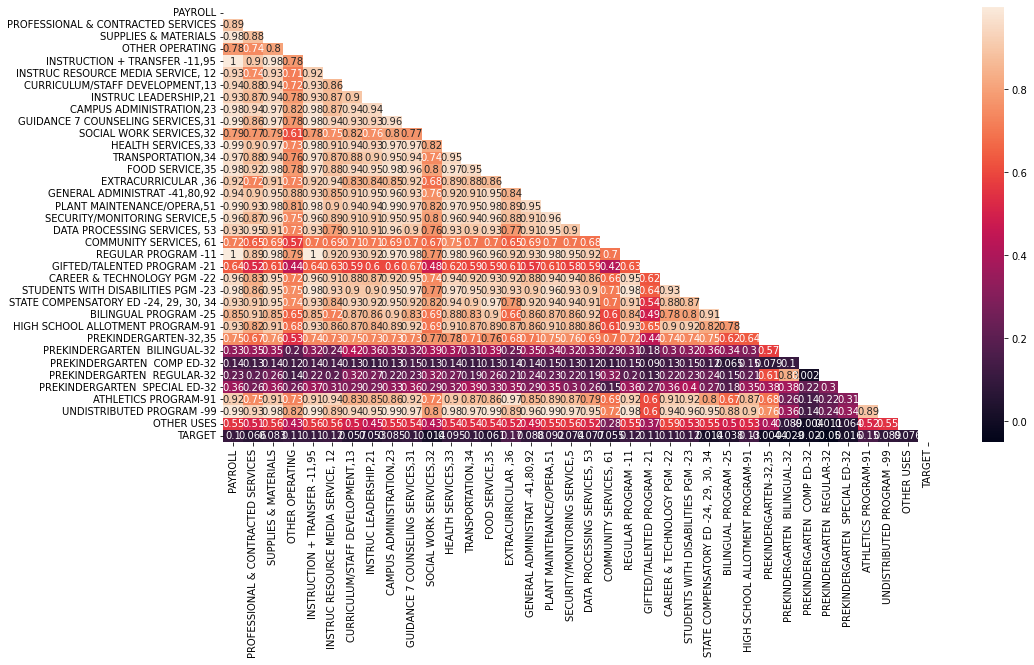

In [65]:
# Correlation between different variables
corr = df.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(16, 8))

# Generate a mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask)

In [66]:
# Test for Normality of Distribution using Shapiro-Wilk Test
for col in df.columns:
    stat, p = shapiro(df[col])
    if p > 0.05:
        print(col + ' - Probably Gaussian')
    else:
        print(col + ' - Probably NOT Gaussian')

DISTRICT - Probably NOT Gaussian
PAYROLL - Probably NOT Gaussian
PROFESSIONAL & CONTRACTED SERVICES - Probably NOT Gaussian
SUPPLIES & MATERIALS - Probably NOT Gaussian
OTHER OPERATING - Probably NOT Gaussian
INSTRUCTION + TRANSFER -11,95 - Probably NOT Gaussian
INSTRUC RESOURCE MEDIA SERVICE, 12 - Probably NOT Gaussian
CURRICULUM/STAFF DEVELOPMENT,13 - Probably NOT Gaussian
INSTRUC LEADERSHIP,21 - Probably NOT Gaussian
CAMPUS ADMINISTRATION,23 - Probably NOT Gaussian
GUIDANCE 7 COUNSELING SERVICES,31 - Probably NOT Gaussian
SOCIAL WORK SERVICES,32 - Probably NOT Gaussian
HEALTH SERVICES,33 - Probably NOT Gaussian
TRANSPORTATION,34 - Probably NOT Gaussian
FOOD SERVICE,35 - Probably NOT Gaussian
EXTRACURRICULAR ,36 - Probably NOT Gaussian
GENERAL ADMINISTRAT -41,80,92 - Probably NOT Gaussian
PLANT MAINTENANCE/OPERA,51 - Probably NOT Gaussian
SECURITY/MONITORING SERVICE,5 - Probably NOT Gaussian
DATA PROCESSING SERVICES, 53 - Probably NOT Gaussian
COMMUNITY SERVICES, 61 - Probably NOT Ga

In [67]:
df.head().T

,0,1,2,3,4
DISTRICT,001902,001903,001904,001906,001907
PAYROLL,6025217,9093950,6659596,3134475,25587063
PROFESSIONAL & CONTRACTED SERVICES,1075904,1514689,927209,373513,5603896
SUPPLIES & MATERIALS,648206,784631,937810,408024,4134969
OTHER OPERATING,809559,303052,278109,105878,1048416
"INSTRUCTION + TRANSFER -11,95",4649118,7043892,4611747,2087166,18807861
"INSTRUC RESOURCE MEDIA SERVICE, 12",66490,117860,51126,19990,167823
"CURRICULUM/STAFF DEVELOPMENT,13",4986,33175,157830,0,535649
"INSTRUC LEADERSHIP,21",270353,66374,0,7905,1033275
"CAMPUS ADMINISTRATION,23",306385,574699,466345,379101,2201907


In [68]:
dfx = df.drop(columns=['DISTRICT'])

In [69]:
df_more30 =  dfx.loc[dfx['TARGET'] > 20]
df_less30 =  dfx.loc[dfx['TARGET'] < 30]

In [70]:
df_more30.shape
df_less30.shape

(1173, 36)

(96, 36)

In [71]:
ALPHA = 0.05

mannwhitneyu_same = []
mannwhitneyu_diff = []

for column in dfx.columns:
    stat, p = mannwhitneyu(df_more30[column], df_less30[column])
    
    if p > ALPHA:
        interpretation = 'SAME (fail to reject H0)'
        print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + column + ' - ' + interpretation)
        mannwhitneyu_same.append(column)
    else:
        interpretation = 'DIFFERENT (reject H0)'
        print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + column + ' - ' + interpretation)
        mannwhitneyu_diff.append(column)

Statistics=78052.500, p=0.000 - PAYROLL - DIFFERENT (reject H0)
Statistics=70120.500, p=0.000 - PROFESSIONAL & CONTRACTED SERVICES - DIFFERENT (reject H0)
Statistics=79275.500, p=0.000 - SUPPLIES & MATERIALS - DIFFERENT (reject H0)
Statistics=73681.500, p=0.000 - OTHER OPERATING - DIFFERENT (reject H0)
Statistics=78348.500, p=0.000 - INSTRUCTION + TRANSFER -11,95 - DIFFERENT (reject H0)
Statistics=84553.500, p=0.000 - INSTRUC RESOURCE MEDIA SERVICE, 12 - DIFFERENT (reject H0)
Statistics=69967.000, p=0.000 - CURRICULUM/STAFF DEVELOPMENT,13 - DIFFERENT (reject H0)
Statistics=71488.000, p=0.000 - INSTRUC LEADERSHIP,21 - DIFFERENT (reject H0)
Statistics=71106.000, p=0.000 - CAMPUS ADMINISTRATION,23 - DIFFERENT (reject H0)
Statistics=72902.000, p=0.000 - GUIDANCE 7 COUNSELING SERVICES,31 - DIFFERENT (reject H0)
Statistics=57182.000, p=0.753 - SOCIAL WORK SERVICES,32 - SAME (fail to reject H0)
Statistics=81384.000, p=0.000 - HEALTH SERVICES,33 - DIFFERENT (reject H0)
Statistics=76350.500, p=

### MODELING

In [72]:
X, y = dfx.iloc[:,:-1],dfx.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=493)

In [73]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [74]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, ...)

In [75]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 19.985289


In [76]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=493)

In [77]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,42.755484,0.457479,42.760619,1.080530
1,38.839818,0.414343,38.860905,1.106412
2,35.311924,0.397585,35.402732,1.153990
3,32.170967,0.372898,32.312739,1.182249
4,29.357326,0.367211,29.539162,1.189255


In [78]:
print((cv_results["test-rmse-mean"]).tail(1))

49    10.605437
Name: test-rmse-mean, dtype: float64


In [79]:
PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.1, 0.3, 0.5, 0.75],
              "max_depth":[2, 5, 7, 10],
              "min_child_weight":[1, 5, 10],
              "learning_rate":[0.1, 0.2, 0.3],
              "n_estimators":[100]}

In [80]:
clf = GridSearchCV(estimator=xg_reg, 
                   param_grid=PARAMETERS,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

In [82]:
clf.fit(X, y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(estimator=XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=0.3,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.1, max_bin=256,
                                    max_cat_t...
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=10,
                                    n_jobs=0, num_parallel_tree=1,
                                    predictor='auto', random_state=0,
                                    reg_alpha=10, ...),
             param_grid={'colsample_bytree': [0.1, 0.3, 0.5, 0.75],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 5, 7, 10],
                         'min_child_weight': [1, 5, 10], 'n_estimators': [100],
                         'subsample': [0.5, 0.75, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [83]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Best parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.75}
Lowest RMSE:  9.955000499962454


In [84]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.75,'learning_rate': 0.1,
                'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.75, 'alpha': 10}

In [85]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[16:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




<AxesSubplot:>

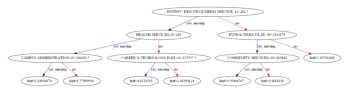

In [86]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

Text(0.5, 1.0, "Predictors of STAAR Student Performance ('MEETS')")

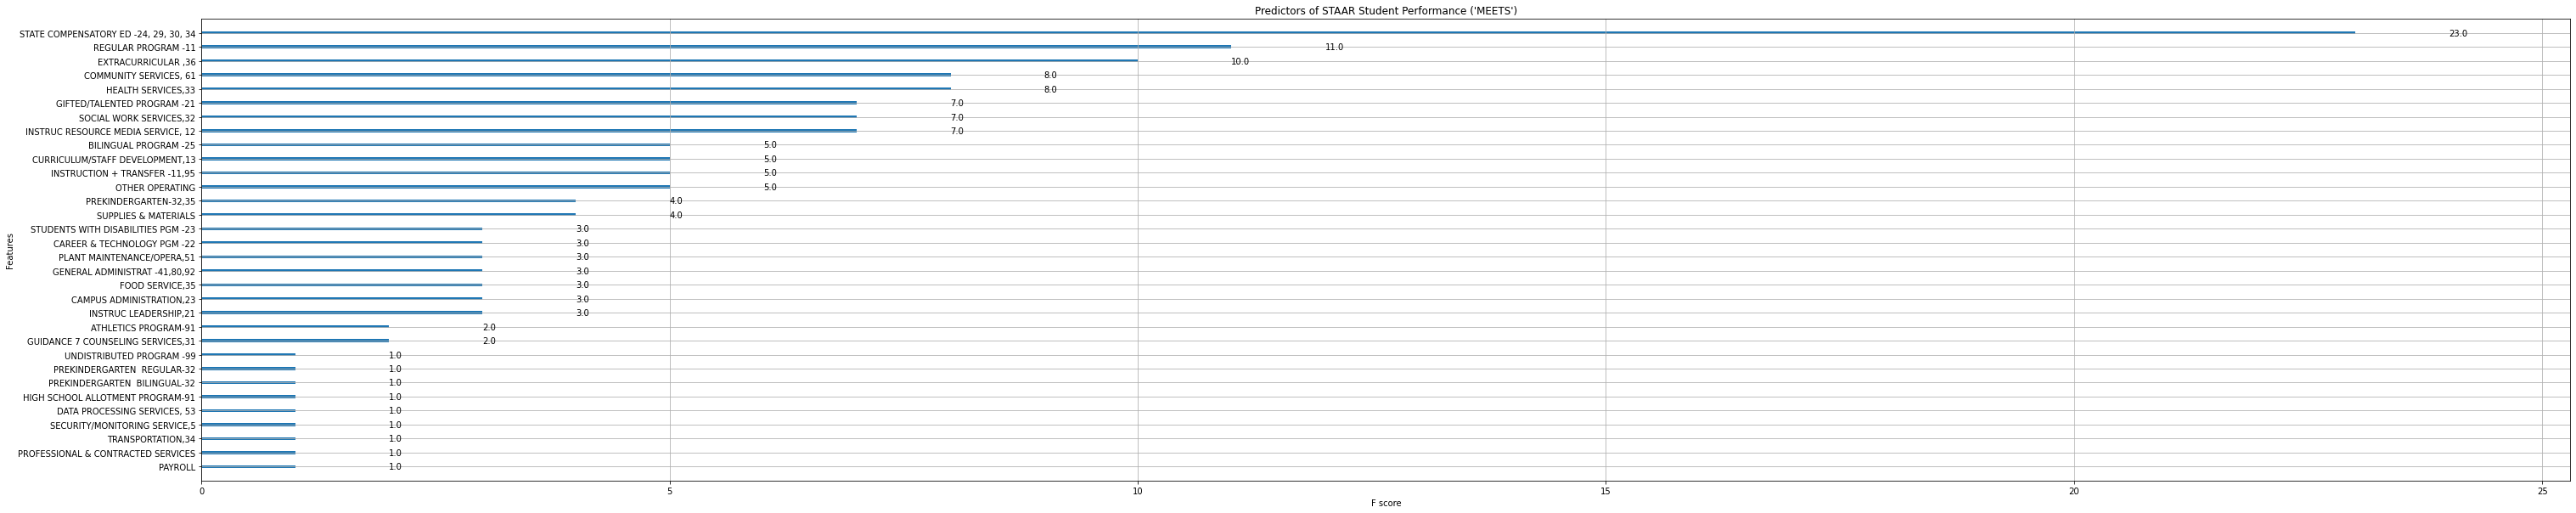

<Figure size 1152x576 with 0 Axes>

In [87]:
xgb.plot_importance(xg_reg)
plt.title("Predictors of STAAR Student Performance ('MEETS')")
plt.rcParams['figure.figsize'] = [16, 8]
plt.show()
plt.savefig("../data/out/MEETS-feature-importance.jpg") #save as jpg

In [89]:
pickle.dump(xg_reg, open('meets-model.pkl','wb'))

# Conclusion